In [1]:
!pip install pyspark

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, to_date

# Initialize Spark session
spark = SparkSession.builder.appName("WildfirePrediction").getOrCreate()

# Load datasets
modis_df = spark.read.csv("/content/fire_archive_M-C61_537264.csv", header=True, inferSchema=True)
wildfire_df = spark.read.csv("/content/fp-historical-wildfire-data-2006-2023.csv", header=True, inferSchema=True)

# Convert dates and round coordinates for spatial join
modis_df = modis_df.withColumn("acq_date", to_date(col("acq_date"), "yyyy-MM-dd"))
wildfire_df = wildfire_df.withColumn("fire_start_date", to_date(col("fire_start_date"), "yyyy-MM-dd"))  # Adjust column name

modis_df = modis_df.withColumn("latitude_rounded", round(col("latitude"), 2))\
                   .withColumn("longitude_rounded", round(col("longitude"), 2))
wildfire_df = wildfire_df.withColumn("latitude_rounded", round(col("fire_location_latitude"), 2))\
                         .withColumn("longitude_rounded", round(col("fire_location_longitude"), 2))

# Join on latitude, longitude, and date
combined_df = modis_df.join(wildfire_df,
                            (modis_df.latitude_rounded == wildfire_df.latitude_rounded) &
                            (modis_df.longitude_rounded == wildfire_df.longitude_rounded) &
                            (modis_df.acq_date == wildfire_df.fire_start_date),
                            "inner")

# Further analysis or predictive modeling goes here


In [8]:
combined_df.show()


+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+------+--------+----+----------------+-----------------+---------+-----------+---------------+------------+----------+----------------------+-----------------------+------------------+--------------------+------------------------+----------------------+-------------------+--------------+---------------+--------------+---------+-------------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+---------+----------------------+----------------------------+-----------+-----------------+--------------+----------+---------+-----------------+-----------------------+----------------+------------------------+------------------------+-----------------+--------------------------+----------------------+-------------------+-----------+-------------------+--------

In [9]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

# Extract temporal features from the date
combined_df = combined_df.withColumn("year", year(col("acq_date")))\
                         .withColumn("month", month(col("acq_date")))\
                         .withColumn("day", dayofmonth(col("acq_date")))\
                         .withColumn("day_of_week", dayofweek(col("acq_date")))


In [10]:
combined_df.show()

+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+------+--------+----+----------------+-----------------+---------+-----------+---------------+------------+----------+----------------------+-----------------------+------------------+--------------------+------------------------+----------------------+-------------------+--------------+---------------+--------------+---------+-------------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+---------+----------------------+----------------------------+-----------+-----------------+--------------+----------+---------+-----------------+-----------------------+----------------+------------------------+------------------------+-----------------+--------------------------+----------------------+-------------------+-----------+-------------------+--------

In [13]:


# Display basic schema
combined_df.printSchema()



root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- brightness: double (nullable = true)
 |-- scan: double (nullable = true)
 |-- track: double (nullable = true)
 |-- acq_date: date (nullable = true)
 |-- acq_time: integer (nullable = true)
 |-- satellite: string (nullable = true)
 |-- instrument: string (nullable = true)
 |-- confidence: integer (nullable = true)
 |-- version: double (nullable = true)
 |-- bright_t31: double (nullable = true)
 |-- frp: double (nullable = true)
 |-- daynight: string (nullable = true)
 |-- type: integer (nullable = true)
 |-- latitude_rounded: double (nullable = true)
 |-- longitude_rounded: double (nullable = true)
 |-- fire_year: integer (nullable = true)
 |-- fire_number: string (nullable = true)
 |-- fire_name: string (nullable = true)
 |-- current_size: double (nullable = true)
 |-- size_class: string (nullable = true)
 |-- fire_location_latitude: double (nullable = true)
 |-- fire_location_longitude: double (

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, month, dayofweek
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
# Preparing data for prediction
# Assembling features into a single vector
feature_columns = ["brightness", "confidence", "temperature", "relative_humidity", "wind_speed"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(combined_df).select("features", col("fire_spread_rate").alias("label"))

# Splitting the data into train and test sets
train_data, test_data = assembled_data.randomSplit([0.7, 0.3], seed=42)

# Define the model
rf_regressor = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=50, maxDepth=5)

# Train the model
rf_model = rf_regressor.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Show sample predictions
predictions.select("features", "label", "prediction").show(5)

Root Mean Squared Error (RMSE) on test data = 2.371207606575494
+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[308.4,35.0,2.0,6...|  0.1|1.0808000000000004|
|[316.7,49.0,25.0,...|  0.5|2.5056666666666665|
|[318.0,78.0,-2.0,...|  0.1|1.3330000000000002|
|[318.9,73.0,26.0,...|  3.0|            2.2325|
|[327.6,84.0,25.0,...|  0.5|3.0890000000000004|
+--------------------+-----+------------------+
only showing top 5 rows



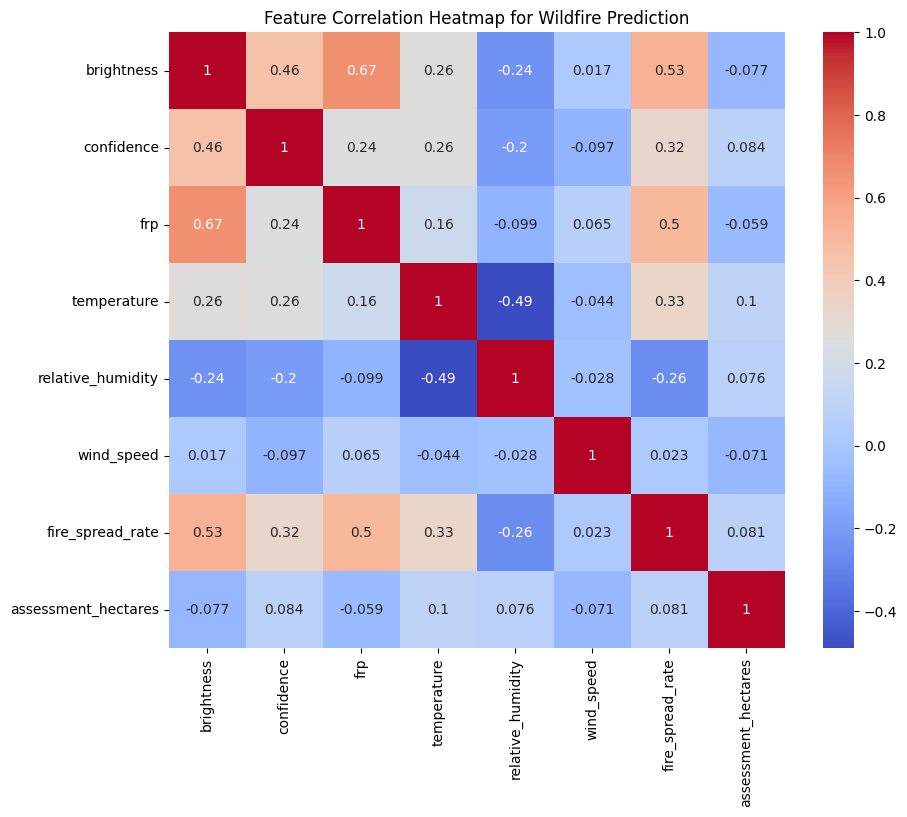

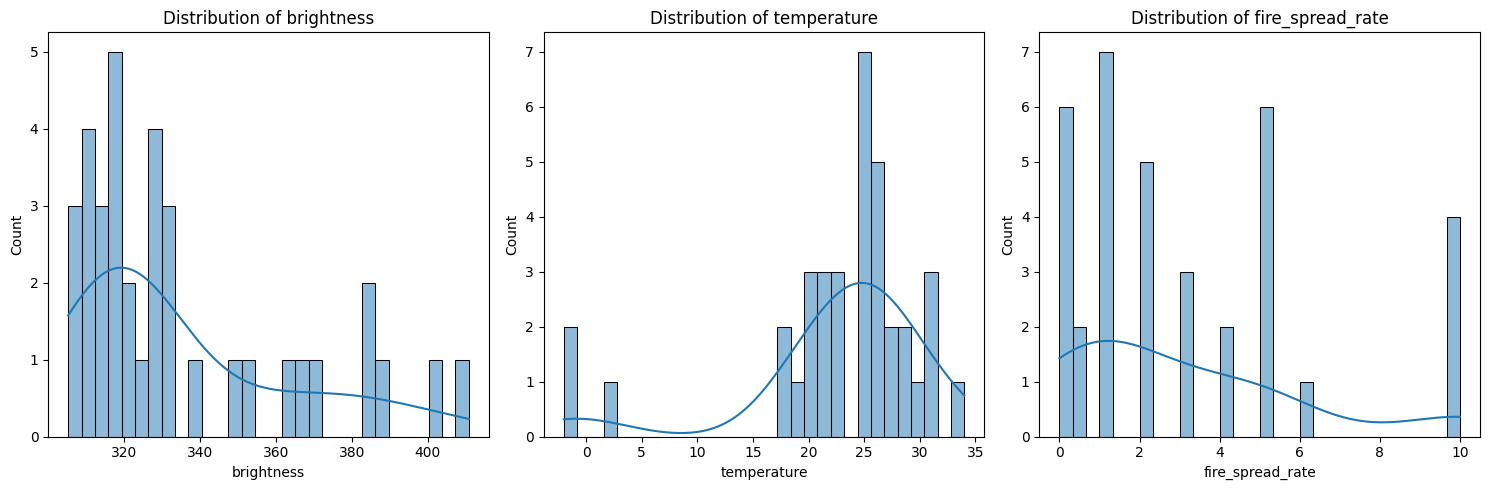

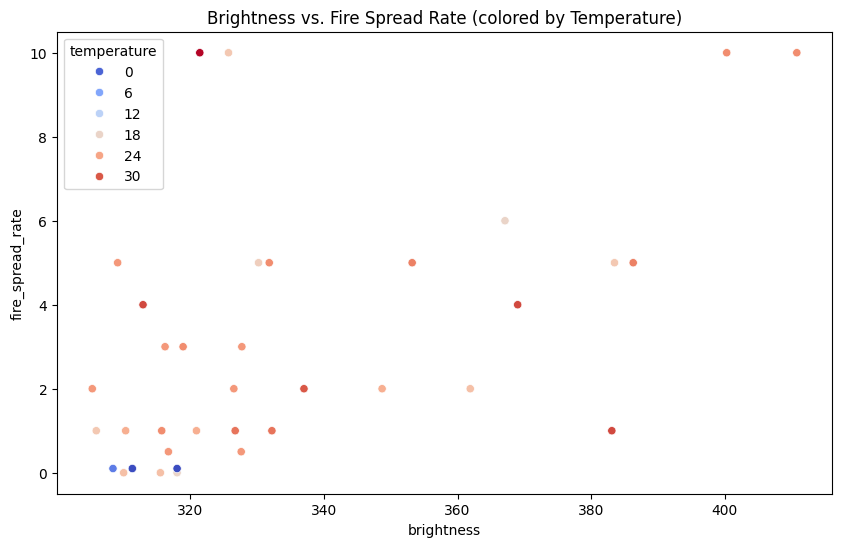

+-------------------+------------------+
|assessment_hectares|        prediction|
+-------------------+------------------+
|               0.01|              5.76|
|                0.5|11.567499999999999|
|                5.0| 2.943005952380952|
|                0.5| 8.495833333333334|
|               15.0| 6.326339285714285|
|                3.0|            16.115|
|                1.5| 8.000833333333333|
|              357.0| 3.348214285714286|
+-------------------+------------------+

Root Mean Squared Error (RMSE) on test data = 125.29106044505619
R2 score on test data = -0.14769751989262847


In [18]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, avg, max, min, when, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# Data Cleaning - Handling missing values, converting data types
data = combined_df.na.fill({'brightness': 0, 'temperature': 0, 'wind_speed': 0, 'relative_humidity': 0})
data = data.withColumn("fire_start_date", to_date(col("fire_start_date"), "yyyy-MM-dd"))

# Feature selection for analysis - Keep relevant columns for correlation and prediction
feature_cols = ["brightness", "confidence", "frp", "temperature", "relative_humidity", "wind_speed",
                "fire_spread_rate", "assessment_hectares"]
data = data.select(feature_cols).dropna()

# Calculate correlation matrix
vector_col = "features"
assembler = VectorAssembler(inputCols=feature_cols, outputCol=vector_col)
data_vector = assembler.transform(data).select(vector_col)
matrix = Correlation.corr(data_vector, vector_col).head()[0].toArray()

# Convert correlation matrix to Pandas DataFrame for heatmap visualization
correlation_df = pd.DataFrame(matrix, columns=feature_cols, index=feature_cols)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap for Wildfire Prediction")
plt.show()

# Additional visualizations - Distribution plots
data_pd = data.toPandas()  # Convert Spark DataFrame to Pandas for matplotlib

# Distribution of temperature, brightness, and fire spread rate
plt.figure(figsize=(15, 5))
for i, col_name in enumerate(["brightness", "temperature", "fire_spread_rate"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data_pd[col_name], kde=True, bins=30)
    plt.title(f"Distribution of {col_name}")
plt.tight_layout()
plt.show()

# Scatter plot for brightness vs. fire spread rate, colored by temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_pd, x="brightness", y="fire_spread_rate", hue="temperature", palette="coolwarm")
plt.title("Brightness vs. Fire Spread Rate (colored by Temperature)")
plt.show()

# Decision - Selecting features for wildfire prediction based on correlation
# Let's use brightness, temperature, wind_speed, and fire_spread_rate for prediction modeling
selected_features = ["brightness", "temperature", "wind_speed", "fire_spread_rate"]

# Building a simple predictive model (Random Forest)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Assemble selected features for modeling
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol="assessment_hectares")

# Pipeline for transforming and modeling
pipeline = Pipeline(stages=[assembler, rf])

# Split data into train and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# Train the model
model = pipeline.fit(train_data)

# Model evaluation on test data
predictions = model.transform(test_data)
predictions.select("assessment_hectares", "prediction").show(10)

# Display model metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="assessment_hectares", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator = RegressionEvaluator(labelCol="assessment_hectares", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R2 score on test data = {r2}")

